In [ ]:
!pip install  torchvision torchaudio  networkx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.0 MB/s eta 0:00:00


In [ ]:
import os, sys
from copy import deepcopy
import numpy as np
import pandas as pd

import torch as th
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
from torch_geometric.data import Data

In [ ]:
import torch
print(torch.__version__)

2.2.1+cu121


In [ ]:
import torch
import pandas as pd
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv('/content/S1File.csv', encoding='ISO-8859-1')
df = df.drop(columns=['county', 'state'])


user_encoder = LabelEncoder()
df['user_encoded'] = user_encoder.fit_transform(df['user'])

edge_index = torch.tensor([df['user_encoded'], df['user_encoded']], dtype=torch.long)

df['cal'] = pd.to_numeric(df['cal'], errors='coerce')

# Option 1: Drop rows where 'cal' is NaN
df = df.dropna(subset=['cal'])


edge_attr = torch.tensor(df[['cal']].values, dtype=torch.float)


# Create edge attributes (calories)
edge_attr = torch.tensor(df[['cal']].values, dtype=torch.float)

# Normalize the node features
node_features = df.drop(['user', 'cal'], axis=1)  # Drop non-feature columns
scaler = StandardScaler()
node_features = scaler.fit_transform(node_features)

# Convert normalized features to tensor
node_features = torch.tensor(node_features, dtype=torch.float)

# Create a PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)


In [ ]:
from torch_geometric.loader import DataLoader
dataset = [data]
loader = DataLoader(dataset, batch_size=32)

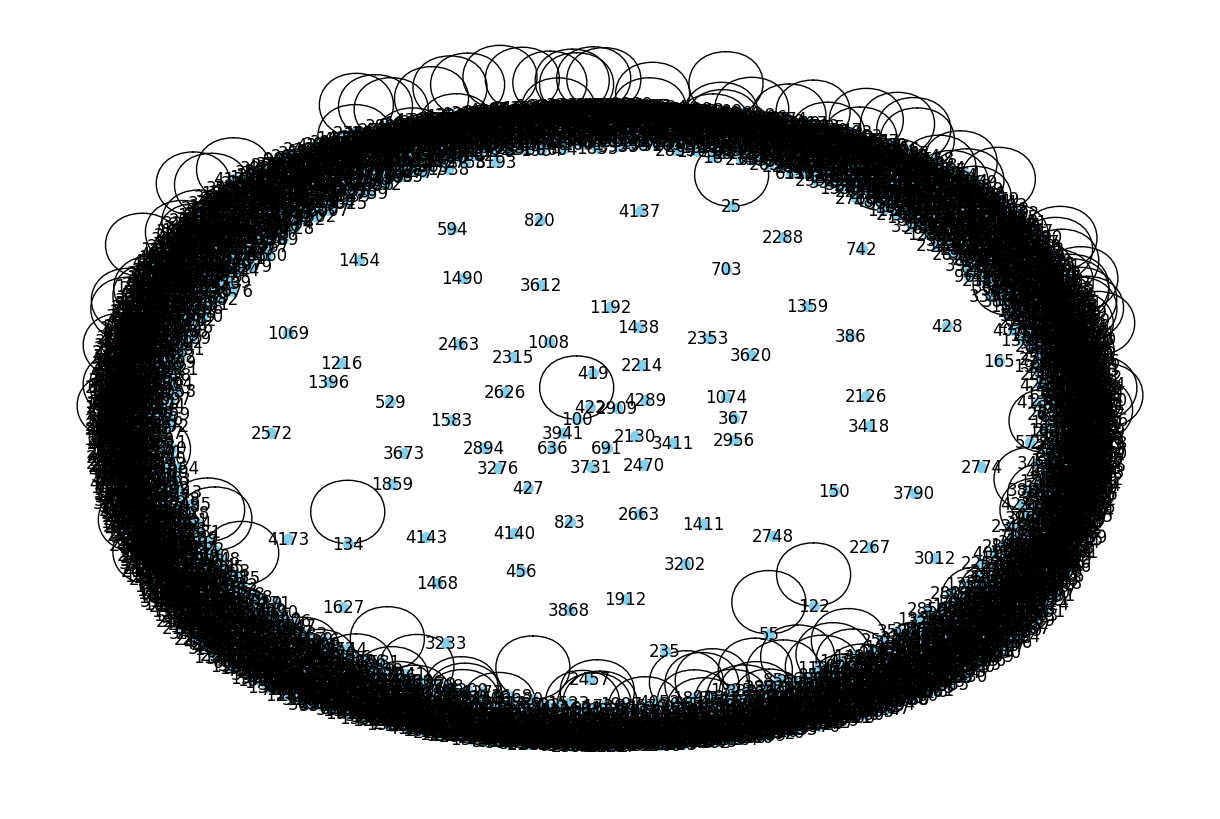

In [ ]:
import torch_geometric.utils as pyg_utils
import networkx as nx
import matplotlib.pyplot as plt

# Assuming 'data' is your PyTorch Geometric Data object

# Convert to networkx graph
G = pyg_utils.to_networkx(data, to_undirected=True)

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=50, edge_color='k')
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

class CalorieRecommendationGNN(torch.nn.Module):
    def __init__(self, num_node_features):
        super(CalorieRecommendationGNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, 8)
        self.fc = torch.nn.Linear(8, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return x

# Load and preprocess the dataset
df = pd.read_csv('/content/S1File.csv', encoding='ISO-8859-1')
df = df.drop(columns=['county', 'state'])
df['user_encoded'] = LabelEncoder().fit_transform(df['user'])
edge_index = torch.tensor([df['user_encoded'], df['user_encoded']], dtype=torch.long)
df['cal'] = pd.to_numeric(df['cal'], errors='coerce').fillna(0)
edge_attr = torch.tensor(df[['cal']].values, dtype=torch.float)

# Filter out non-numeric columns
node_features = df.select_dtypes(include=[np.number])

# Apply StandardScaler to the node features
scaler = StandardScaler()
node_features_scaled = scaler.fit_transform(node_features)
node_features_tensor = torch.tensor(node_features_scaled, dtype=torch.float)

# Set target values (calories)
target_values = torch.tensor(df['cal'].values, dtype=torch.float).view(-1, 1)

# Create the data object
data = Data(x=node_features_tensor, edge_index=edge_index, edge_attr=edge_attr, y=target_values)

# Generate train and test masks
num_nodes = data.num_nodes
train_mask = torch.rand(num_nodes) < 0.8
test_mask = ~train_mask

data.train_mask = train_mask
data.test_mask = test_mask

# Initialize the model
model = CalorieRecommendationGNN(num_node_features=data.num_node_features)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
model.eval()
with torch.no_grad():
    test_pred = model(data)
    test_loss = criterion(test_pred[data.test_mask], data.y[data.test_mask])
    print(f'Test Loss: {test_loss.item()}')


Epoch 0, Loss: 44625.84375
Epoch 10, Loss: 44181.96875
Epoch 20, Loss: 43228.171875
Epoch 30, Loss: 41270.015625
Epoch 40, Loss: 37589.33984375
Epoch 50, Loss: 31466.849609375
Epoch 60, Loss: 22995.1875
Epoch 70, Loss: 13879.4990234375
Epoch 80, Loss: 7983.5830078125
Epoch 90, Loss: 6146.27001953125
Epoch 100, Loss: 6067.13818359375
Epoch 110, Loss: 5246.25634765625
Epoch 120, Loss: 4580.48876953125
Epoch 130, Loss: 4202.234375
Epoch 140, Loss: 3704.895751953125
Epoch 150, Loss: 3530.624267578125
Epoch 160, Loss: 3187.95556640625
Epoch 170, Loss: 3149.468994140625
Epoch 180, Loss: 2784.416259765625
Epoch 190, Loss: 2780.64453125
Test Loss: 437.83123779296875


In [ ]:
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert the predictions and actual values to numpy arrays for compatibility with scikit-learn
true_values = data.y[data.test_mask].cpu().detach().numpy()
predicted_values = test_pred[data.test_mask].cpu().detach().numpy()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values, predicted_values)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values, predicted_values)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(true_values, predicted_values, squared=False)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Absolute Error (MAE): 20.3353
Mean Squared Error (MSE): 437.8312
Root Mean Squared Error (RMSE): 20.9244
